In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import figurefirst as fifi
import scipy.fftpack

import pynumdiff

import pickle
import time

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
from multiprocessing import Pool
import multiprocessing

In [3]:
def get_data(problem, noise, dt, timeseries_length):
    r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], dt=dt)
    x, x_truth, dxdt_truth, _ = r
    t = np.linspace(0, timeseries_length, len(x))
    #dt = np.mean(np.diff(t))
    return x, x_truth, dxdt_truth, t, dt

In [4]:
def get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params):
    
    #params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_general)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    
    return rmse, errcorr

In [5]:
def get_params_for_method(method, method_parent):
    if method_parent == 'linear_model' and method == 'savgoldiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in range(3, 300, 5):
                if p1 >= p2:
                    continue
                else:
                    params_list.append([p1,p2])
    if method_parent == 'kalman_smooth' and method == 'constant_acceleration':
        params_list = []
        for p1 in np.logspace(-8, 8, 50):
            for p2 in np.logspace(-8, 8, 50):
                params_list.append([p1,p2])
    if method_parent == 'smooth_finite_difference' and method == 'butterdiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in np.logspace(-8, -0.7, 100):
                params_list.append([p1,p2])
    if method_parent == 'total_variation_regularization' and method == 'jerk':
        params_list = []
        for p1 in np.logspace(-8, 8, 400):
                params_list.append([p1])
                
                
    return params_list

In [6]:
def get_pareto_plot_data_for_params_list(inputs):
    x, x_truth, dxdt_truth, dt, method_parent, method, params = inputs
    try:
        r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    except:
        r = None
        e = None
    return r, e

In [7]:
def get_pareto_plot_data(x, x_truth, dxdt_truth, dt, method, method_parent, gamma_range, num_gammas=10):
    params_list = get_params_for_method(method, method_parent)
    
    # parallel params computations
    inputs = []
    for p in params_list:
        i = [x, x_truth, dxdt_truth, dt, method_parent, method, p]
        inputs.append(i)


    pool = Pool(20)
    result = pool.map(get_pareto_plot_data_for_params_list, inputs)
    pool.close()
    pool.join()

    rmses = np.vstack(result)[:,0].tolist()
    errcorrs = np.vstack(result)[:,1].tolist()
        
    rmses_gamma = []
    errcorrs_gamma = []
    params_gamma = []
    successful_gammas = []
    
    gammas = np.exp(np.linspace(np.log(gamma_range[0]), np.log(gamma_range[1]), num_gammas)) 
    for gamma in gammas:
        try:
            params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=gamma)
            x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
            r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
            rmses_gamma.append(r)
            errcorrs_gamma.append(e)
            successful_gammas.append(gamma)
            params_gamma.append(params)
        except:
            print('FAILED', method, method_parent, gamma)
            
    rmses = np.array(rmses)
    errcorrs = np.array(errcorrs)
    rmses_gamma = np.array(rmses_gamma)
    errcorrs_gamma = np.array(errcorrs_gamma)
    
    return rmses, errcorrs, rmses_gamma, errcorrs_gamma, params_gamma, successful_gammas

In [8]:
def do_pareto_calcs_for_method(method, method_parent, 
                               problem, noise, dt, timeseries_length, 
                               x, x_truth, dxdt_truth, t):
    gamma_range = [1e-4, 1e3]

    rmses, errcorrs, rmses_gamma, errcorrs_gamma, params_gamma, successful_gammas = get_pareto_plot_data(x, x_truth, dxdt_truth, dt, 
                                                                        method, method_parent, 
                                                                        gamma_range, num_gammas=20)

    metadata = {'noise': noise,
                'dt': dt,
                'timeseries_length': timeseries_length,
                'problem': problem,
                'method': method,
                'method_parent': method_parent,
                'params': params_gamma,
                'gammas': successful_gammas}
    
    data = {   'rmses': rmses,
               'errcorrs': errcorrs,
               'rmses_gamma': rmses_gamma,
               'errcorrs_gamma': errcorrs_gamma,
               'metadata': metadata}
    

    fname = 'pareto_data/pareto_data_' + method + '_' + method_parent + '_' + problem + '_' + str(noise) + '_' + str(dt) + '_' + str(timeseries_length) + '.pickle'
    f = open(fname, 'wb')
    pickle.dump(data, f)
    f.close()

In [9]:
def get_filenames(path, contains, does_not_contain=['~', '.pyc']):
    cmd = 'ls ' + '"' + path + '"'
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                filelist.append( os.path.join(path, filename) )
    return filelist

In [10]:
problems = ['pi_control', 'sine', 'triangle'] # ['lorenz_x', 'pop_dyn', 

method_parent_pairs = [['savgoldiff', 'linear_model'],
                       ['constant_acceleration', 'kalman_smooth'],
                       ['butterdiff', 'smooth_finite_difference'],
                       ['jerk', 'total_variation_regularization'],
                      ]

noises = [0.001, 0.01, 0.1, 0.5]
dts = [0.001, 0.01, 0.1]
timeseries_lengths = [4, 8, 16]

In [12]:
for problem in problems:
    print(problem)
    for noise in noises:
        for dt in dts:
            for timeseries_length in timeseries_lengths:
                x, x_truth, dxdt_truth, t, dt = get_data(problem, noise, dt, timeseries_length)

                for method_parent_pair in method_parent_pairs:
                    print(method_parent_pair)
                    method, method_parent = method_parent_pair
                    
                    fname = 'pareto_data/pareto_data_' + method + '_' + method_parent + '_' + problem + '_' + str(noise) + '_' + str(dt) + '_' + str(timeseries_length) + '.pickle'
                    filenames_done = get_filenames('pareto_data/', '.pickle')
                    if fname in filenames_done:
                        continue
                    
                    method, method_parent = method_parent_pair
                    do_pareto_calcs_for_method(method, method_parent, 
                                               problem, noise, dt, timeseries_length, 
                                               x, x_truth, dxdt_truth, t)

pi_control
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model'

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
FAILED jerk total_variation_regularization 0.00010000000000000009
FAILED jerk total_variation_regularization 0.0002335721469090123
FAILED jerk total_variation_regularization 0.0005455594781168522
FAILED jerk total_variation_regularization 0.001274274985703135
FAILED jerk total_variation_regularization 0.0029763514416313187
FAILED jerk total_variation_regularization 0.006951927961775603
FAILED jerk total_variation_regularization 0.016237767391887214
FAILED jerk total_variation_regularization 0.0379269019073225
FAILED jerk total_variation_regulari

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']


/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  

['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']


/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: i

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encounte

['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']


/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overfl

['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']


/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/p

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encounte

['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']
['jerk', 'total_variation_regularization

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


['jerk', 'total_variation_regularization']
['savgoldiff', 'linear_model']
['constant_acceleration', 'kalman_smooth']
['butterdiff', 'smooth_finite_difference']


/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/p

['jerk', 'total_variation_regularization']
FAILED jerk total_variation_regularization 0.00010000000000000009
FAILED jerk total_variation_regularization 0.0002335721469090123
FAILED jerk total_variation_regularization 0.0005455594781168522
FAILED jerk total_variation_regularization 0.001274274985703135
FAILED jerk total_variation_regularization 0.0029763514416313187
FAILED jerk total_variation_regularization 0.006951927961775603
FAILED jerk total_variation_regularization 0.016237767391887214
FAILED jerk total_variation_regularization 0.0379269019073225
FAILED jerk total_variation_regularization 0.08858667904100821
FAILED jerk total_variation_regularization 0.20691380811147872
FAILED jerk total_variation_regularization 0.4832930238571745
FAILED jerk total_variation_regularization 1.1288378916846884
FAILED jerk total_variation_regularization 2.636650898730355
FAILED jerk total_variation_regularization 6.158482110660253
FAILED jerk total_variation_regularization 14.384498882876619
FAILED j

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/cavem

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encounte

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encounte

['jerk', 'total_variation_regularization']
FAILED jerk total_variation_regularization 0.00010000000000000009
FAILED jerk total_variation_regularization 0.0002335721469090123
FAILED jerk total_variation_regularization 0.0005455594781168522
FAILED jerk total_variation_regularization 0.001274274985703135
FAILED jerk total_variation_regularization 0.0029763514416313187
FAILED jerk total_variation_regularization 0.006951927961775603
FAILED jerk total_variation_regularization 0.016237767391887214
FAILED jerk total_variation_regularization 0.0379269019073225
FAILED jerk total_variation_regularization 0.08858667904100821
FAILED jerk total_variation_regularization 0.20691380811147872
FAILED jerk total_variation_regularization 0.4832930238571745
FAILED jerk total_variation_regularization 1.1288378916846884
FAILED jerk total_variation_regularization 2.636650898730355
FAILED jerk total_variation_regularization 6.158482110660253
FAILED jerk total_variation_regularization 14.384498882876619
FAILED j

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


['jerk', 'total_variation_regularization']
FAILED jerk total_variation_regularization 0.00010000000000000009
FAILED jerk total_variation_regularization 0.0002335721469090123
FAILED jerk total_variation_regularization 0.0005455594781168522
FAILED jerk total_variation_regularization 0.001274274985703135
FAILED jerk total_variation_regularization 0.0029763514416313187
FAILED jerk total_variation_regularization 0.006951927961775603
FAILED jerk total_variation_regularization 0.016237767391887214
FAILED jerk total_variation_regularization 0.0379269019073225
FAILED jerk total_variation_regularization 0.08858667904100821
FAILED jerk total_variation_regularization 0.20691380811147872
FAILED jerk total_variation_regularization 0.4832930238571745
FAILED jerk total_variation_regularization 1.1288378916846884
FAILED jerk total_variation_regularization 2.636650898730355
FAILED jerk total_variation_regularization 6.158482110660253
FAILED jerk total_variation_regularization 14.384498882876619
FAILED j

OSError: [Errno 12] Cannot allocate memory

In [51]:
test = 1

In [9]:
i = 0
for problem in problems:
    for noise in noises:
        for dt in dts:
            for timeseries_length in timeseries_lengths:
                i += 1
print(i)

180


In [10]:
method = 'constant_acceleration'
method_parent = 'kalman_smooth'
params_list = get_params_for_method(method, method_parent)
print(len(params_list))

2500


In [11]:
x, x_truth, dxdt_truth, t, dt = get_data(problem, noise, dt, timeseries_length)

In [13]:
params = params_list[0]
t = time.time()
r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
print('Time: ', time.time() - t)

Time:  0.23907804489135742


In [16]:
gamma = 1
t = time.time()
params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=gamma)
x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
print('Time: ', time.time() - t)

Time:  11.361514568328857


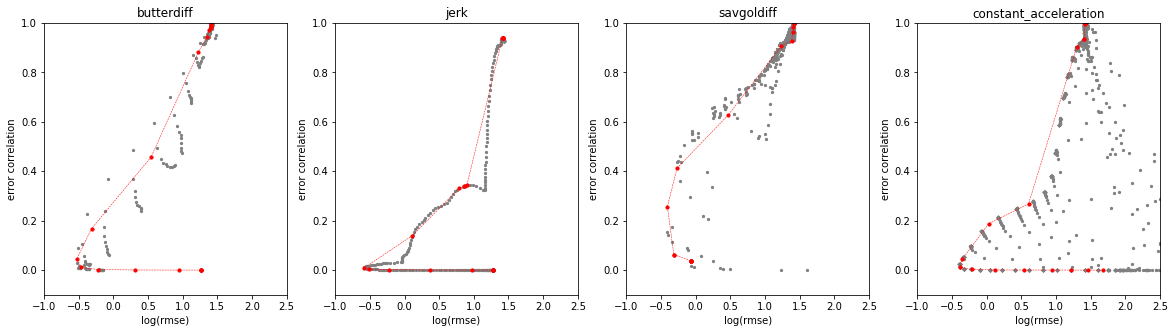

In [123]:
fig = plt.figure(figsize=(20,5))

for i, method in enumerate(['butterdiff', 'jerk', 'savgoldiff', 'constant_acceleration']):
    f = open(method + '_pareto_data.pickle', 'rb')
    data = pickle.load(f)
    f.close()
    
    ax = fig.add_subplot(1,4,i+1)
    
    
    ax.scatter(np.log(data['rmses']), data['errcorrs'], c='gray', s=5)
    ax.scatter(np.log(data['rmses_gamma']), data['errcorrs_gamma'], c='red', s=10)
    ax.plot(np.log(data['rmses_gamma']), data['errcorrs_gamma'], '--', color='red', linewidth=0.5)
    
    ax.set_xlim(-1, 2.5)
    ax.set_ylim(-0.1,1)
    
    ax.set_xlabel('log(rmse)')
    ax.set_ylabel('error correlation')
    ax.set_title(method)